## Install Libraries

In [ ]:
# Uncomment to install phasorpy and ptufile
print("Installing necessary libraries...")
#!pip install numpy
#!pip install phasorpy > /dev/null 2>&1
#!pip install ptufile > /dev/null 2>&1
#!pip install PyQt5 > /dev/null 2>&1
#!pip install napari[all] > /dev/null 2>&1
#!pip install git+https://github.com/RoccoDAnt/napari-superres.git > /dev/null 2>&1
#!pip install cmcrameri
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Import required modules and functions



In [ ]:
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_ptu
from phasorpy.plot import plot_signal_image, plot_phasor_image, PhasorPlot

from phasorpy.phasor import phasor_from_signal, phasor_threshold, phasor_filter_median
from phasorpy.phasor import (
    lifetime_to_signal,
    phasor_calibrate,
    phasor_from_lifetime,
    phasor_from_signal,
)

import numpy as np

import scipy.signal

from matplotlib import pyplot
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter


from napari_superres.core_mssr import mssr_class
mssr_instance = mssr_class()
import cmcrameri.cm as cmc

/usr/local/lib/python3.11/dist-packages/pytools/persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


This exception is what's causing cl equals None: clGetPlatformIDs failed: PLATFORM_NOT_FOUND_KHR


/usr/local/lib/python3.11/dist-packages/liquid_engine/__opencl__.py:125: UserWarning: tap... tap... tap... COMPUTER SAYS NO (OpenCL)!
  warnings.warn("tap... tap... tap... COMPUTER SAYS NO (OpenCL)!")
/usr/local/lib/python3.11/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Optional dependecy Dask_image is not installed. Implementations using it will be ignored.


## Define common parameters used throughout the simulation:



In [ ]:
## Temporal parameters
tau_1 = 1
tau_2 = 4
lifetimes = [tau_1, tau_2]  # lifetime in ns


frequency = 80.0  # fundamental frequency in MHz
period = (1 / frequency) * 1e3 # period of fundamental frequency in ns
reference_lifetime = 0.06  # lifetime of reference signal in ns


settings = {
    'samples': 256,  # number of samples to synthesize
    'mean': 1e4,  # average intensity
    'background': 0.0,  # no signal from background
    'zero_phase': 0.08,  # location of IRF peak in the phase
    'zero_stdev': None,  # standard deviation of IRF in radians
}

## Spatial parameters
pxsz = 5                                             # Pixel size in nm
# Optics
sigma_nm = 100                                       # PSF sigma in nanometers. Equvalent to a FWHM of 235 nm
sigma_px = int(sigma_nm / pxsz)                      # PSF sigma in pixels. Equvalent to a FWHM of 235 nm

# Image
x_dim = y_dim = 127                                  # Image Size in pixels
center = np.ceil(x_dim/2).astype(int)
cy = center


# MSSR limit distance
#cx_1 = int(center - 0.8*sigma_px)
#cx_2 = int(center + 0.8*sigma_px)

# Sparrow limit distance
cx_1 = center - sigma_px
cx_2 = center + sigma_px


# Visualization
color = 'PRGn' #'cmc.batlowK'
title_size = 18
axtitles = 18
ticksize = 12
legendtitles = '16'


## Time-domain, single-exponential

To synthesize separate signals for each lifetime component at once,
omit the lifetime fractions:



In [ ]:
signal, _, times = lifetime_to_signal(frequency, lifetimes, **settings)
reference_signal, _, _ = lifetime_to_signal(frequency, reference_lifetime, **settings)
signal_1 = signal[0]
signal_2 = signal[1]

## Create a TD emission stack with two fluorophores exhibiting different lifetimes.

(127, 127, 256)


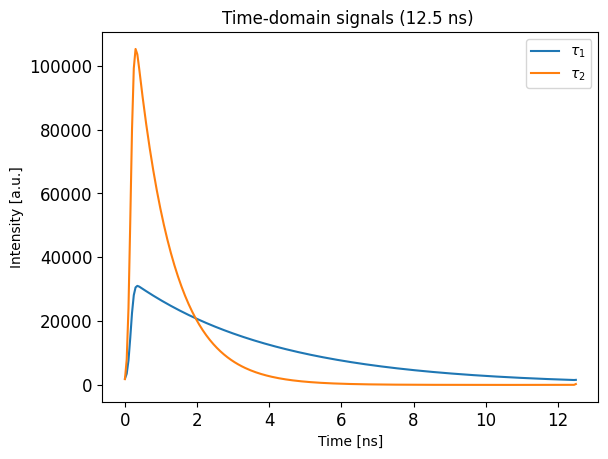

In [ ]:
##### create an TD emission x,y,t stack for each fluorophore
t_dim = settings['samples']
# Create fluorescence data stacks initialized to zero
F1xy = np.zeros((y_dim, x_dim, t_dim))
F2xy = np.zeros((y_dim, x_dim, t_dim))
F1xy[cy, cx_1, :] = signal.T[:,1] #Left fluorophore with tau_2
F2xy[cy, cx_2, :] = signal.T[:,0] #Right fluorophore with tau_1

print(F1xy.shape)

# Create figure and axis
fig, ax = plt.subplots()

# Define the title, labels, and formatting
ax.set(
    title=f'Time-domain signals ({period} ns) ',
    xlabel='Time [ns]',
    ylabel='Intensity [a.u.]',
)

# Plot fluorophore signals
ax.plot(times, F1xy[cy, cx_1, :], label='$\\tau_1$')
ax.plot(times, F2xy[cy, cx_2, :], label='$\\tau_2$')

# Customize ticks
ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y', labelsize=ticksize)

# Add legend
ax.legend(loc=1)

# Display the plot
plt.show()

## Convolved the modelled signals with the PSF

In [ ]:

# Create a Gaussian-like PSF
def gaussian_psf(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf /= np.sum(psf)  # Normalize PSF
    return psf

# Define PSF size and sigma
sigma_psf = sigma_px  # Standard deviation of PSF

# Generate PSF
PSF = gaussian_psf(x_dim, sigma_psf)
#plt.axis('off')
#plt.imshow(PSF, cmap="gray")
# Convolve each frame in the (x, y, t) stack
F1xy_convolved = np.empty_like(F1xy)
F2xy_convolved = np.empty_like(F2xy)

for t in range(t_dim):
    F1xy_convolved[:, :, t] = scipy.signal.fftconvolve(F1xy[:, :, t], PSF, mode='same')
    F2xy_convolved[:, :, t] = scipy.signal.fftconvolve(F2xy[:, :, t], PSF, mode='same')


## Synthesize a TD-FLIM reference signal, taking as an example a homogeneous solution of fluorescein with a lifetime of 4.2 ns.

In [ ]:
img_reference_signal = np.zeros((x_dim, y_dim, t_dim))

for x in range(img_reference_signal.shape[0]):  # Loop over x-dimension
    for y in range(img_reference_signal.shape[1]):  # Loop over y-dimension
        img_reference_signal[x, y, :] = reference_signal  # Assign time-domain signal

#assert reference_signal.attrs['frequency'] == frequency
img_reference_mean, img_reference_real, img_reference_imag = phasor_from_signal(
    img_reference_signal
)



## Calibrate

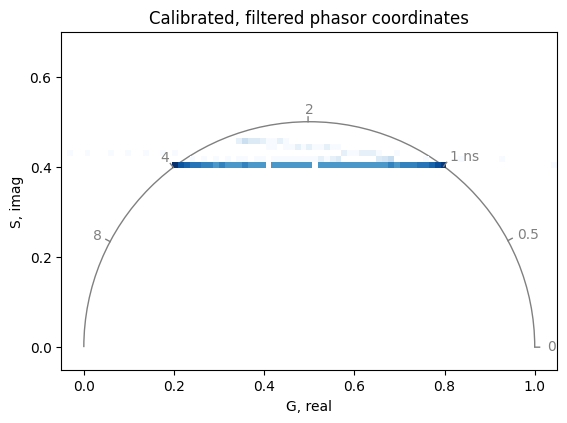

In [ ]:
TD_FLIM_signal =F1xy_convolved + F2xy_convolved

#For MS: mean_MS, real_MS, imag_MS
#mean_MS, real_MS, imag_MS = phasor_from_signal(TD_FLIM_signal, axis = 2)

# Calibrate phasor for Sparrow coordinates using reference
#real_MS, imag_MS = phasor_calibrate(real_MS, imag_MS, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_MS, imag_MS, bins =85)

#For Sparrow: mean_spa, real_spa, imag_spa
mean_spa, real_spa, imag_spa = phasor_from_signal(TD_FLIM_signal, axis = 2)

# Calibrate phasor for Sparrow coordinates using reference
real_spa, imag_spa = phasor_calibrate(real_spa, imag_spa, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime)
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_spa, imag_spa, bins =85)


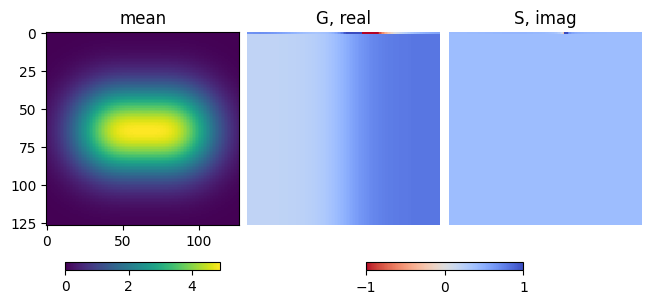

In [ ]:
plot_phasor_image(mean_spa, real_spa, imag_spa)

## Sharpen the mean image with MSSR

In [ ]:
### Parameters for MSSR
fwhm = 2.35 * sigma_px  # Full Width at Half Maximum
amp = 1  # Amplitude
order = 1  # Order
mesh = True  # Optional, default is True
ftI = False  # Optional, default is False
intNorm = False  # Optional, default is True

progress: 100%|██████████| 49/49 [00:00<00:00, 81.21it/s]


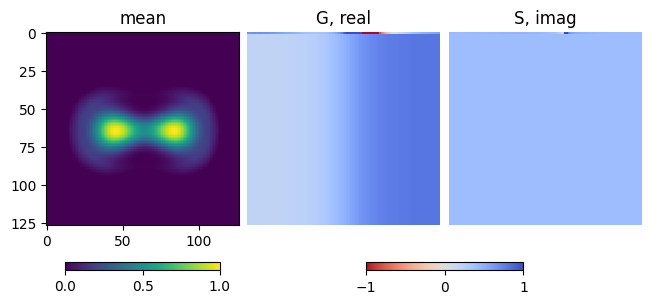

In [ ]:
#mean_MS_mssr1 = mssr_instance.sfMSSR(img=mean_MS, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
#plot_phasor_image(mean_MS_mssr1, real_MS, imag_MS)


mean_spa_mssr1 = mssr_instance.sfMSSR(img=mean_spa, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
plot_phasor_image(mean_spa_mssr1, real_spa, imag_spa)

## From here Mario will do the magic

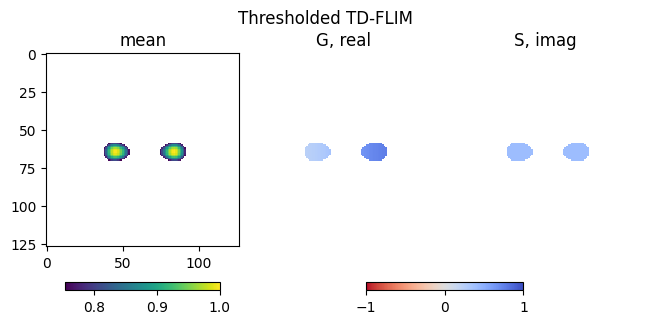

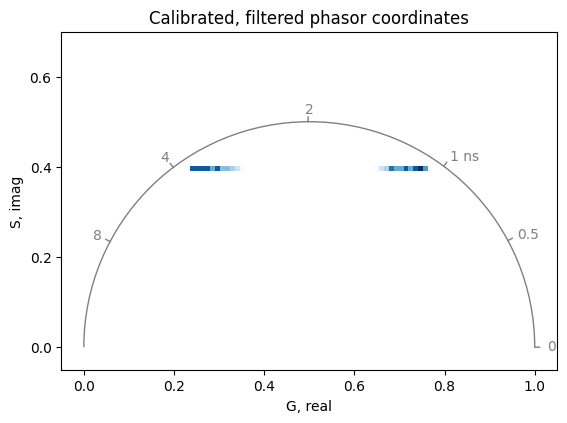

In [ ]:
from phasorpy.phasor import phasor_threshold

color = 'PRGn'

#Threshold for MSSR
#mean_th_MS, real_th_MS, imag_th_MS = phasor_threshold(mean_MS_mssr1, real_MS, imag_MS, mean_min=0.75)
#plot_phasor_image(mean_th_MS, real_th_MS, imag_th_MS, title='Thresholded TD-FLIM')
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_th_MS, imag_th_MS, bins = 100)

#Threshold for Sparrow
mean_th_spa, real_th_spa, imag_th_spa = phasor_threshold(mean_spa_mssr1, real_spa, imag_spa, mean_min=0.75)
plot_phasor_image(mean_th_spa, real_th_spa, imag_th_spa, title='Thresholded TD-FLIM')
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_th_spa, imag_th_spa, bins = 100)


In [ ]:
T = (1 / frequency) * 1e3
print(T)

12.5


# TD-FL image (lifetime maps) from Phasor coordinates #

In [ ]:
def td_flim_figure(G,S,laser_period_in_seconds, harmonic = 1, mod_correction = True, mod_lower_limit = 0.1, phase_correction = True, phase_lower_limit = 0.1, tau_m_correction = True, factor_tm = 1, tau_p_correction = True, factor_tp = 1, num_bins = 100, color = color):
    from matplotlib.ticker import FormatStrFormatter
    # A function to calculate the modulation, phase delay, modulation lifetimes and phase lifetimes
    #i.e. the TD-FLIM image it also contaains the instructions for plotting the results
    T = laser_period_in_seconds
    T_nano = T*1e9          #to show in nanoseconds
    n = harmonic # number of harmonic (default 1)
    w = (2 * np.pi * n) / T
    w_nano = (2 * np.pi) / T_nano
    # Setting epsilon to avoid division by zero
    epsilon = np.nan

    G = np.where(G > 0, G, epsilon)
    S = np.where(S > 0, S, epsilon)

    mod = np.sqrt(G**2 + S**2)
    phi = np.arctan2(S,G)

    mod_min = 1 / np.sqrt((1 + (w_nano*tau_2)**2))
    mod_max = 1 / np.sqrt((1 + (w_nano*tau_1)**2))

    phi_max = np.arctan(w_nano*tau_2)
    phi_min = np.arctan(w_nano*tau_1)

    #Corrections
    #Mod correction
    if mod_correction:
        mod = np.where(mod >= mod_lower_limit, mod, epsilon)

    tau_m = (1 / w) * np.sqrt(np.maximum((1/(mod**2))-1,0))
    tau_m = tau_m*1e9   #to show in nanoseconds

    #Phase correction
    quarter_pi = np.arctan(1)
    phi[phi==quarter_pi] = epsilon

    if phase_correction:
        upper_limit = np.min([np.pi - phase_lower_limit, np.max(phi)-np.max(phi) * 0.01])  # Define your upper threshold
        phi = np.where((phase_lower_limit <= phi) & (phi <= upper_limit), phi, epsilon)

    tau_p = (1 / w) * (np.tan(phi))
    tau_p = tau_p*1e9       #to show in nanoseconds

    #tau_p correction
    if tau_p_correction:
        tau_p = np.where(tau_p <= (T_nano/factor_tp), tau_p, epsilon)
        tau_p_label = f'ns (/{factor_tp})'
    else:
        tau_p[tau_p > T_nano] = epsilon
        tau_p_label = 'ns'

    #tau_mod correction
    if tau_m_correction:
        tau_m = np.where(tau_m <= (T_nano/factor_tm), tau_m, epsilon)
        tau_m_label = f'ns (/{factor_tm})'
    else:
        tau_m[tau_m > T_nano] = epsilon
        tau_m_label = 'ns'

    # G and S correction
    if mod_correction or phase_correction:
        G_corr = mod * np.cos(phi)
        S_corr = mod * np.sin(phi)

    elif tau_m_correction or tau_p_correction:
        w_nano = (2 * np.pi) / T_nano
        G_corr = np.sqrt(1 / (((w_nano * tau_m)**2 + 1) * ((w_nano * tau_p)**2 + 1)))
        G_corr = np.where(G_corr < 1, G_corr, epsilon)
        S_corr = w_nano * tau_p * G_corr

    else:
        G_corr = G
        S_corr = S


    #Output figure

    color = color
    titlesize = 20
    suptitle = 22
    axsize = 18
    ticksize = 16
    legsize = 16
    s = 400
    color_1 = 'y' #360f5a
    color_2 = 'r'
    color_3 = 'k'

    ##Images of TD_FLIM and the phasor plot
    f, ax = plt.subplots(2,2, figsize = (8.5,8.5))

    #Modulation Map
    im00 = ax[0,0].imshow(mod, cmap=color, vmin = mod_min, vmax= mod_max)
    # Scatter plots
    ax[0,0].scatter(cx_1, center, color=color_1, linewidth=2.5, marker='+', s=s, label = 'position of $\u03c4_1$')
    ax[0,0].scatter(cx_2, center, color=color_2, linewidth=2.5, marker='+', s=s, label = 'position of $\u03c4_2$')
    ax[0,0].scatter(center, center, color=color_3, linewidth=2.5, marker='+', s=s, label = 'position of $\u03c4_{sp}$')
    ax[0,0].axis('off')
    ax[0,0].set_title('Modulation Map', fontsize=titlesize)
    cbar00 = f.colorbar(im00, ax = ax[0,0], fraction=0.046, pad=0.04)
    cbar00.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cbar00.set_label('a.u.', fontsize=axsize)
    cbar00.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
    ax[0,0].legend(bbox_to_anchor=(1.4, -0.23), loc='lower center', ncol=3, fontsize = legsize) #-0.2
    #ax[0,0].set_box_aspect(1)

    #Phase Map
    im01 = ax[0,1].imshow(phi, cmap=color, vmin= phi_min, vmax=phi_max)
    # Scatter plots
    ax[0,1].scatter(cx_1, center, color=color_1, linewidth=2.5, marker='+', s=s)
    ax[0,1].scatter(cx_2, center, color=color_2, linewidth=2.5, marker='+', s=s)
    ax[0,1].scatter(center, center, color=color_3, linewidth=2.5, marker='+', s=s)
    ax[0,1].axis('off')
    ax[0,1].set_title('Phase Map', fontsize=titlesize)
    cbar01 = f.colorbar(im01, ax = ax[0,1], fraction=0.046, pad=0.04)
    cbar01.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cbar01.set_label('radians', fontsize=axsize)
    cbar01.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
    #ax[0,1].set_box_aspect(1)

    #Tau_m Map
    im10 = ax[1,0].imshow(tau_m, cmap=color, vmin = tau_1, vmax=tau_2)
    # Scatter plots
    ax[1,0].scatter(cx_1, center, color=color_1, linewidth=2.5, marker='+', s=s)
    ax[1,0].scatter(cx_2, center, color=color_2, linewidth=2.5, marker='+', s=s)
    ax[1,0].scatter(center, center, color=color_3, linewidth=2.5, marker='+', s=s)
    ax[1,0].axis('off')
    ax[1,0].set_title('Modulation Lifetime, $\u03c4_M$', fontsize=titlesize)
    cbar10 = f.colorbar(im10, ax = ax[1,0], fraction=0.046, pad=0.04)
    cbar10.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar10.set_label(tau_m_label, fontsize=axsize)
    cbar10.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
    #ax[1,0].set_box_aspect(1)

    #Tau_p Map
    im11 = ax[1,1].imshow(tau_p, cmap=color, vmin = tau_1, vmax=tau_2)
    # Scatter plots
    ax[1,1].scatter(cx_1, center, color=color_1, linewidth=2.5, marker='+', s=s)
    ax[1,1].scatter(cx_2, center, color=color_2, linewidth=2.5, marker='+', s=s)
    ax[1,1].scatter(center, center, color=color_3, linewidth=2.5, marker='+', s=s)
    ax[1,1].axis('off')
    ax[1,1].set_title('Phase Lifetime, $\u03c4_{\u03C6}$', fontsize=titlesize)
    cbar11 = f.colorbar(im11, ax = ax[1,1], fraction=0.046, pad=0.04)
    cbar11.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar11.set_label(tau_p_label, fontsize=axsize)
    cbar11.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
    #ax[1,1].set_box_aspect(1)

    f.suptitle('TD-FLIM images',x=0.55, y=0.99, fontsize = suptitle)
    f.subplots_adjust(wspace=0.3, hspace=0.35, top=0.87, bottom=0.1, left=0.05, right=0.95)
    plt.show()

    return mod, tau_m, phi, tau_p, G_corr, S_corr, f

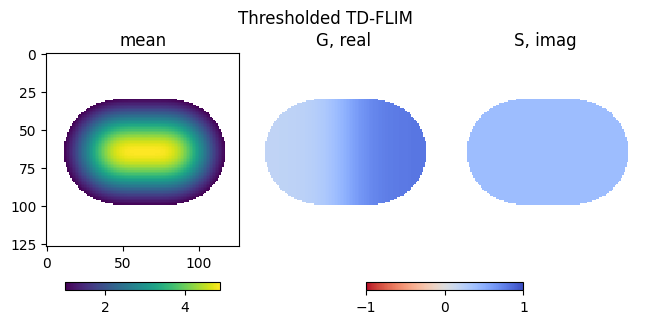

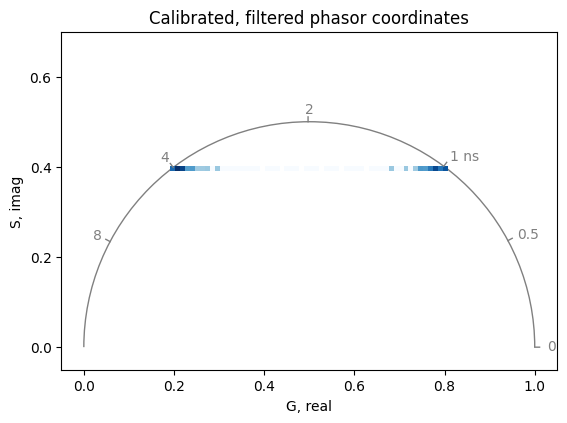

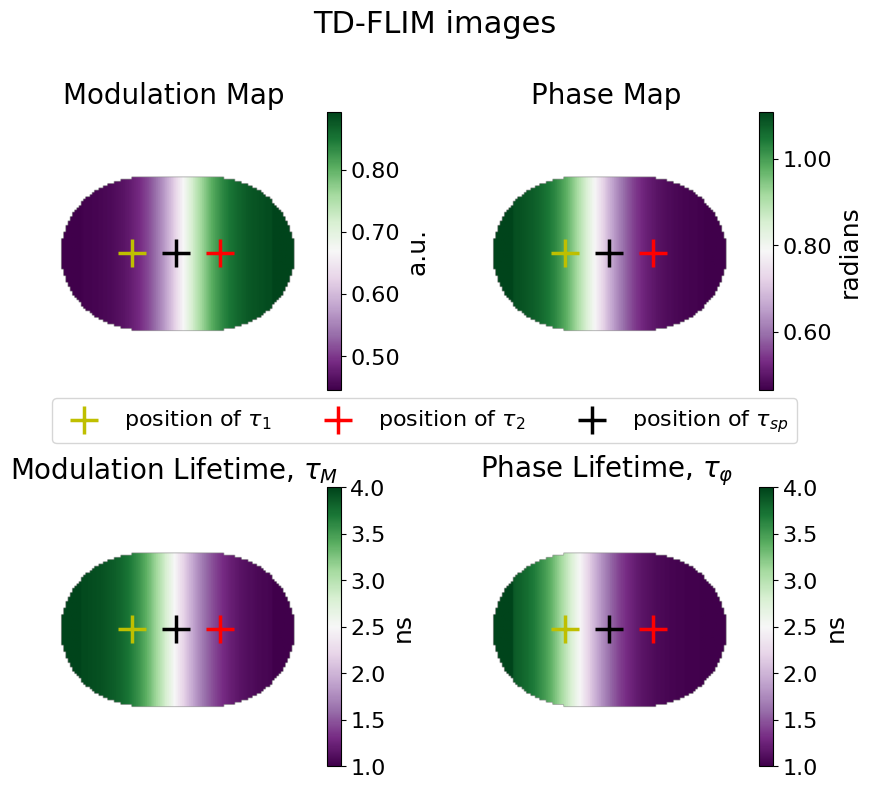

In [ ]:
# TD-FLIM figure of raw Sparrow limit image

T = (1 / frequency) * 1e3
laser_period_in_seconds = T * 1e-9
mod_lower_limit = 0.36
phase_lower_limit = 0.1
factor_tm = 1
factor_tp = 1
bins = 100
color = 'PRGn'

#Threshold for Raw Sparrow
mean_th_spa_r, real_th_spa_r, imag_th_spa_r = phasor_threshold(mean_spa, real_spa, imag_spa, mean_min=1)
plot_phasor_image(mean_th_spa_r, real_th_spa_r, imag_th_spa_r, title='Thresholded TD-FLIM')
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_th_spa_r, imag_th_spa_r, bins = 100)


mod_spa, tau_m_spa, phase_spa, tau_p_spa, _, _, f = td_flim_figure(real_th_spa_r ,imag_th_spa_r, laser_period_in_seconds, harmonic = 1, mod_correction = False, mod_lower_limit=mod_lower_limit, phase_correction = False, phase_lower_limit=phase_lower_limit, tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False, factor_tp=factor_tp, num_bins=30, color = color)



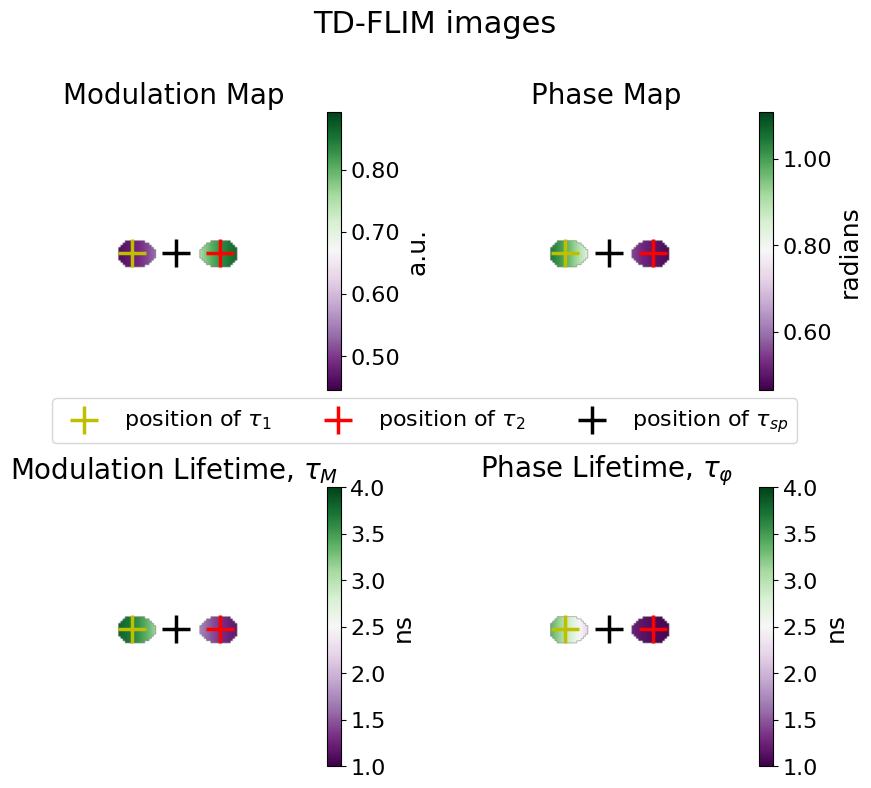

In [ ]:
# Parameters for TD-FLIM figure
T = (1 / frequency) * 1e3
laser_period_in_seconds = T * 1e-9
mod_lower_limit = 0.36
phase_lower_limit = 0.1
factor_tm = 1
factor_tp = 1
bins = 100
color = 'PRGn'

#TD-FLIM for MS
#mod_th_MS, tau_m_th_MS, phase_th_MS, tau_p_th_MS, _, _, f = td_flim_figure(real_th_MS,imag_th_MS,laser_period_in_seconds, harmonic = 1, mod_correction = False, mod_lower_limit=mod_lower_limit, phase_correction = False, phase_lower_limit=phase_lower_limit, tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False, factor_tp=factor_tp, num_bins=30, color = color)

#TD-FLIM for Sparrow
mod_th_spa, tau_m_th_spa, phase_th_spa, tau_p_th_spa, _, _, f = td_flim_figure(real_th_spa,imag_th_spa,laser_period_in_seconds, harmonic = 1, mod_correction = False, mod_lower_limit=mod_lower_limit, phase_correction = False, phase_lower_limit=phase_lower_limit, tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False, factor_tp=factor_tp, num_bins=30, color = color)



# Cursors #

In [ ]:
import matplotlib.pyplot as plt

from phasorpy.color import CATEGORICAL
from phasorpy.cursors import (
    mask_from_circular_cursor,
    mask_from_elliptic_cursor,
    mask_from_polar_cursor,
    pseudo_color,
)
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_lsm
from phasorpy.phasor import phasor_from_signal, phasor_threshold
from phasorpy.plot import PhasorPlot

# Polar cursors #

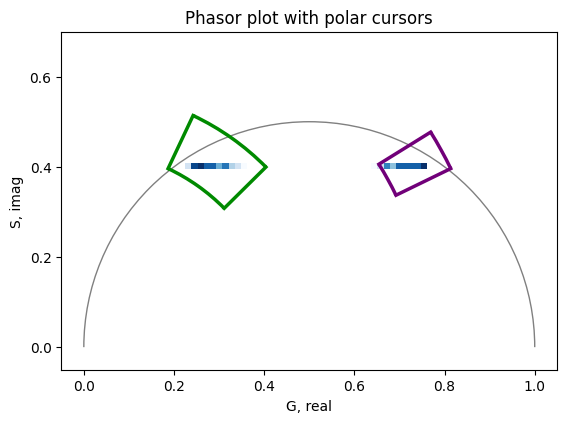

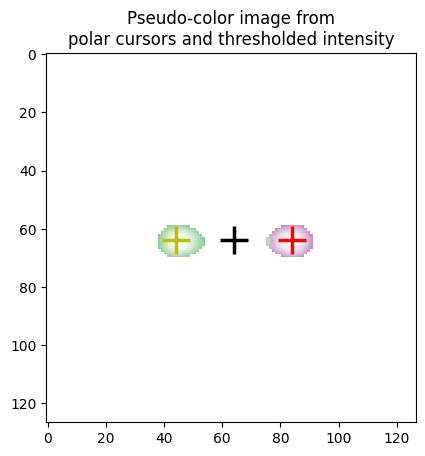

In [ ]:
#Real and Imaginary matrices from which to calculate phasors
real = real_th_spa
imag = imag_th_spa
intensity = mean_th_spa

#Phase and Modulation limits for cursors

#cursor_coord = [tau_1 center /sp/ tau_2 center]
phase_min     =      [0.78   , 0, 0.453]
phase_max     =      [1.13   , 0, 0.555]
modulation_min =     [0.438  , 0, 0.77]
modulation_max =     [0.568  , 0, 0.905]

line = 2.5
color = 'Blues'
bins = 80
titlesize = 20
suptitle = 22
axsize = 18
ticksize = 16
legsize = 16
s = 400
color_1 = 'y' #360f5a
color_2 = 'k'
color_3 = 'r'

polar_mask = mask_from_polar_cursor(
    real, imag, phase_min, phase_max, modulation_min, modulation_max
)

plot = PhasorPlot(allquadrants=False, title='Phasor plot with polar cursors')
plot.hist2d(real, imag, cmap=color, bins = bins)
for i in range(len(phase_min)):
    plot.polar_cursor(
        phase=phase_min[i],
        phase_limit=phase_max[i],
        modulation=modulation_min[i],
        modulation_limit=modulation_max[i],
        color=CATEGORICAL[i + 2],
        linestyle='-', linewidth = line
    )
plot.show()

pseudo_color_MS = pseudo_color(*polar_mask, intensity = intensity, colors=CATEGORICAL[2:])

fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from\npolar cursors and thresholded intensity')
ax.imshow(pseudo_color_MS)
ax.scatter(cx_1, center, color=color_1, linewidth=2.5, marker='+', s=s)
ax.scatter(center, center, color=color_2, linewidth=2.5, marker='+', s=s)
ax.scatter(cx_2, center, color=color_3, linewidth=2.5, marker='+', s=s)
#plt.axis('off')
plt.show()

# Intensity map


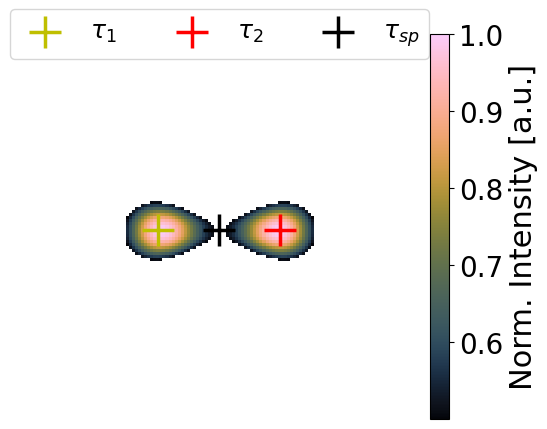

In [ ]:
fig = mean_th_spa
x_1 = cx_1
x_2 = cx_2
title = 'Intensity'
barlabel = 'Norm. Intensity [a.u.]'
titlesize = 25
s =500
legend = 18
axsize = 22
ticksize = 20
labels =['0.0$\u03c3$', '1.6$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$','4.0$\u03c3$', '6.0$\u03c3$', "Dip"]
color = 'cmc.batlowK'

# Create figure and axis
plt.figure(figsize=(7, 5))
im = plt.imshow(fig, cmap=color)

# Scatter plots
plt.scatter(x_1, center, color='y', linewidth=2.5, marker='+', s=s, label = '$\u03c4_1$')
plt.scatter(x_2, center, color='r', linewidth=2.5, marker='+', s=s, label = '$\u03c4_2$')
plt.scatter(center, center, color='k', linewidth=2.5, marker='+', s=s, label = '$\u03c4_{sp}$')
#plt.title(title, fontsize = titlesize, pad = 25)

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label(barlabel, fontsize = axsize)  # Add a label if needed
#ticks = np.linspace(min-0.001, max, 5)  # 5 evenly spaced ticks from 0.45 to 1.0
#cbar.set_ticks(ticks)
#cbar.ax.set_yticklabels([f'{tick:.1f}' for tick in ticks])
cbar.ax.tick_params(labelsize=ticksize)

# Hide axis
plt.axis('off')
plt.legend(ncols=len(labels), bbox_to_anchor=(0.51, 1),loc = 'center', fontsize=legend)

# Show plot
plt.show()

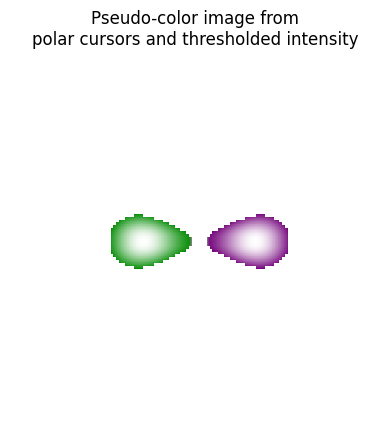

In [ ]:

pseudo_color_MS = pseudo_color(*polar_mask, intensity = intensity, colors=CATEGORICAL[2:])

fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from\npolar cursors and thresholded intensity')
ax.imshow(pseudo_color_MS)
plt.axis('off')
plt.show()

# Lifetimes at different sigma positions #

In [ ]:
# Both fluorophores in the center
cx_1_0s = center
cx_2_0s = center

# MS limit distance
cx_1_MS = int(center - 0.8 * sigma_px)
cx_2_MS = int(center + 0.8 * sigma_px)

# Sparrow limit distance
cx_1_spa = center - sigma_px
cx_2_spa = center + sigma_px

# Rayleigh limit distance
cx_1_ray = int(center - 1.25 * sigma_px)
cx_2_ray = int(center + 1.25 * sigma_px)

# 3s, No diffraction-limited distance
cx_1_3s = int(center - 1.5 * sigma_px)
cx_2_3s = int(center + 1.5 * sigma_px)

# 4s, No diffraction-limited distance
cx_1_4s = int(center - 2 * sigma_px)
cx_2_4s = int(center + 2 * sigma_px)

# 6s, No diffraction-limited distance
cx_1_6s = int(center - 3 * sigma_px)
cx_2_6s = int(center + 3 * sigma_px)

sigmas = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0] #Number of points of sigma values to be plotted

#Indices

index_tm1_MS = np.argwhere(np.round(tau_m_th_MS[center,:]) == 1.0)
index_tm1_spa = np.argwhere(np.round(tau_m_th_spa[center,:]) == 1.0)
index_tm1_ray = np.argwhere(np.round(tau_m_th_ray[center,:]) == 1.0)
index_tm1_3s = np.argwhere(np.round(tau_m_th_3s[center,:]) == 1.0)
index_tm1_4s = np.argwhere(np.round(tau_m_th_4s[center,:]) == 1.0)
index_tm1_6s = np.argwhere(np.round(tau_m_th_6s[center,:]) == 1.0)
index_tm2_MS = np.argwhere(np.round(tau_m_th_MS[center,:]) == 4.0)
index_tm2_spa = np.argwhere(np.round(tau_m_th_spa[center,:]) == 4.0)
index_tm2_ray = np.argwhere(np.round(tau_m_th_ray[center,:]) == 4.0)
index_tm2_3s = np.argwhere(np.round(tau_m_th_3s[center,:]) == 4.0)
index_tm2_4s = np.argwhere(np.round(tau_m_th_4s[center,:]) == 4.0)
index_tm2_6s = np.argwhere(np.round(tau_m_th_6s[center,:]) == 4.0)

index_tp1_MS = np.argwhere(np.round(tau_p_th_MS[center,:]) == 1.0)
index_tp1_spa = np.argwhere(np.round(tau_p_th_spa[center,:]) == 1.0)
index_tp1_ray = np.argwhere(np.round(tau_p_th_ray[center,:]) == 1.0)
index_tp1_3s = np.argwhere(np.round(tau_p_th_3s[center,:]) == 1.0)
index_tp1_4s = np.argwhere(np.round(tau_p_th_4s[center,:]) == 1.0)
index_tp1_6s = np.argwhere(np.round(tau_p_th_6s[center,:]) == 1.0)
index_tp2_MS = np.argwhere(np.round(tau_p_th_MS[center,:]) == 4.0)
index_tp2_spa = np.argwhere(np.round(tau_p_th_spa[center,:]) == 4.0)
index_tp2_ray = np.argwhere(np.round(tau_p_th_ray[center,:]) == 4.0)
index_tp2_3s = np.argwhere(np.round(tau_p_th_3s[center,:]) == 4.0)
index_tp2_4s = np.argwhere(np.round(tau_p_th_4s[center,:]) == 4.0)
index_tp2_6s = np.argwhere(np.round(tau_p_th_6s[center,:]) == 4.0)

# Function to safely extract index
def safe_extract_index(arr,i=0):
    if arr.size > 0:
        return arr[i][0] # when needed another index rather tha 0, for example to extract the last point use -1
    else:
        return np.nan

# Both fluorophores in the center
cx_1_0s = center
cx_2_0s = center

# MS limit distance
cx_1_MS = int(center - 0.8 * sigma_px)
cx_2_MS = int(center + 0.8 * sigma_px)

# Sparrow limit distance
cx_1_spa = center - sigma_px
cx_2_spa = center + sigma_px

# Rayleigh limit distance
cx_1_ray = int(center - 1.25 * sigma_px)
cx_2_ray = int(center + 1.25 * sigma_px)

# 3s, No diffraction-limited distance
cx_1_3s = int(center - 1.5 * sigma_px)
cx_2_3s = int(center + 1.5 * sigma_px)

# 4s, No diffraction-limited distance
cx_1_4s = int(center - 2 * sigma_px)
cx_2_4s = int(center + 2 * sigma_px)

# 6s, No diffraction-limited distance
cx_1_6s = int(center - 3 * sigma_px)
cx_2_6s = int(center + 3 * sigma_px)

sigmas = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0] #Number of points of sigma values to be plotted

#Indices

index_tm1_MS = np.argwhere(np.round(tau_m_th_MS[center,:]) == 1.0)
index_tm1_spa = np.argwhere(np.round(tau_m_th_spa[center,:]) == 1.0)
index_tm1_ray = np.argwhere(np.round(tau_m_th_ray[center,:]) == 1.0)
index_tm1_3s = np.argwhere(np.round(tau_m_th_3s[center,:]) == 1.0)
index_tm1_4s = np.argwhere(np.round(tau_m_th_4s[center,:]) == 1.0)
index_tm1_6s = np.argwhere(np.round(tau_m_th_6s[center,:]) == 1.0)
index_tm2_MS = np.argwhere(np.round(tau_m_th_MS[center,:]) == 4.0)
index_tm2_spa = np.argwhere(np.round(tau_m_th_spa[center,:]) == 4.0)
index_tm2_ray = np.argwhere(np.round(tau_m_th_ray[center,:]) == 4.0)
index_tm2_3s = np.argwhere(np.round(tau_m_th_3s[center,:]) == 4.0)
index_tm2_4s = np.argwhere(np.round(tau_m_th_4s[center,:]) == 4.0)
index_tm2_6s = np.argwhere(np.round(tau_m_th_6s[center,:]) == 4.0)

index_tp1_MS = np.argwhere(np.round(tau_p_th_MS[center,:]) == 1.0)
index_tp1_spa = np.argwhere(np.round(tau_p_th_spa[center,:]) == 1.0)
index_tp1_ray = np.argwhere(np.round(tau_p_th_ray[center,:]) == 1.0)
index_tp1_3s = np.argwhere(np.round(tau_p_th_3s[center,:]) == 1.0)
index_tp1_4s = np.argwhere(np.round(tau_p_th_4s[center,:]) == 1.0)
index_tp1_6s = np.argwhere(np.round(tau_p_th_6s[center,:]) == 1.0)
index_tp2_MS = np.argwhere(np.round(tau_p_th_MS[center,:]) == 4.0)
index_tp2_spa = np.argwhere(np.round(tau_p_th_spa[center,:]) == 4.0)
index_tp2_ray = np.argwhere(np.round(tau_p_th_ray[center,:]) == 4.0)
index_tp2_3s = np.argwhere(np.round(tau_p_th_3s[center,:]) == 4.0)
index_tp2_4s = np.argwhere(np.round(tau_p_th_4s[center,:]) == 4.0)
index_tp2_6s = np.argwhere(np.round(tau_p_th_6s[center,:]) == 4.0)

# Function to safely extract index
def safe_extract_index(arr,i=0):
    if arr.size > 0:
        return arr[i][0] # when needed another index rather tha 0, for example to extract the last point use -1
    else:
        return np.nan

# Extracting Lifetimes from the new centroid of each fluorophore
LTm_1 = [tau_m_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, safe_extract_index(index_tm1_MS)], tau_m_th_spa[center, safe_extract_index(index_tm1_spa)], tau_m_th_ray[center,safe_extract_index(index_tm1_ray)], round(tau_m_th_3s[center,cx_1_3s]), round(tau_m_th_4s[center,cx_1_4s]), round(tau_m_th_6s[center,cx_1_6s])]
LTm_2 = [tau_m_th_0s[center, cx_2_0s] ,tau_m_th_MS[center, safe_extract_index(index_tm2_MS,-1)], tau_m_th_spa[center, safe_extract_index(index_tm2_spa,-1)], tau_m_th_ray[center,safe_extract_index(index_tm2_ray,-1)], round(tau_m_th_3s[center,cx_2_3s]), round(tau_m_th_4s[center,cx_2_4s]), round(tau_m_th_6s[center,cx_2_6s])]
LTp_1 = [tau_p_th_0s[center, cx_1_0s] ,tau_p_th_MS[center, safe_extract_index(index_tp1_MS)], tau_p_th_spa[center, safe_extract_index(index_tp1_spa)], tau_p_th_ray[center,safe_extract_index(index_tp1_ray)], round(tau_p_th_3s[center,cx_1_3s]), round(tau_p_th_4s[center,cx_1_4s]), round(tau_p_th_6s[center,cx_1_6s])]
LTp_2 = [tau_p_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, safe_extract_index(index_tp2_MS,-1)], tau_p_th_spa[center, safe_extract_index(index_tp2_spa,-1)], tau_p_th_ray[center,safe_extract_index(index_tp2_ray,-1)], round(tau_p_th_3s[center,cx_2_3s]), round(tau_p_th_4s[center,cx_2_4s]), round(tau_p_th_6s[center,cx_2_6s])]
LTm_sp = [tau_m_th_0s[center, center] ,tau_m_th_MS[center, center], tau_m_th_spa[center, center], tau_m_th_ray[center,center], tau_m_th_3s[center,center], tau_m_th_4s[center,center], round(np.nan_to_num(tau_m_th_6s[center,center], nan=0))]
LTp_sp = [tau_p_th_0s[center, center] ,tau_p_th_MS[center, center], tau_p_th_spa[center, center], tau_p_th_ray[center,center], tau_p_th_3s[center,center], tau_p_th_4s[center,center], round(np.nan_to_num(tau_p_th_6s[center,center], nan=0))]

# Lifetimes from each center cx_i

LTm_1_c = [tau_m_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, cx_1_MS], tau_m_th_spa[center, cx_1_spa], tau_m_th_ray[center,cx_1_ray], round(tau_m_th_3s[center,cx_1_3s]), round(tau_m_th_4s[center,cx_1_4s]), round(tau_m_th_6s[center,cx_1_6s])]
LTm_2_c = [tau_m_th_0s[center, cx_2_0s] ,tau_m_th_MS[center, cx_2_MS], tau_m_th_spa[center, cx_2_spa], tau_m_th_ray[center,cx_2_ray], round(tau_m_th_3s[center,cx_2_3s]), round(tau_m_th_4s[center,cx_2_4s]), round(tau_m_th_6s[center,cx_2_6s])]
LTp_1_c = [tau_p_th_0s[center, cx_1_0s] ,tau_p_th_MS[center, cx_1_MS], tau_p_th_spa[center, cx_1_spa], tau_p_th_ray[center,cx_1_ray], round(tau_p_th_3s[center,cx_1_3s]), round(tau_p_th_4s[center,cx_1_4s]), round(tau_p_th_6s[center,cx_1_6s])]
LTp_2_c = [tau_p_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, cx_2_MS], tau_p_th_spa[center, cx_2_spa], tau_p_th_ray[center,cx_2_ray], round(tau_p_th_3s[center,cx_2_3s]), round(tau_p_th_4s[center,cx_2_4s]), round(tau_p_th_6s[center,cx_2_6s])]
LTm_sp_c = [tau_m_th_0s[center, center] ,tau_m_th_MS[center, center], tau_m_th_spa[center, center], tau_m_th_ray[center,center], tau_m_th_3s[center,center], tau_m_th_4s[center,center], round(np.nan_to_num(tau_m_th_6s[center,center], nan=0))]
LTp_sp_c = [tau_p_th_0s[center, center] ,tau_p_th_MS[center, center], tau_p_th_spa[center, center], tau_p_th_ray[center,center], tau_p_th_3s[center,center], tau_p_th_4s[center,center], round(np.nan_to_num(tau_p_th_6s[center,center], nan=0))]

#points = tau_m_th_spa[cx_1_spa, cx_1_spa]

NameError: name 'tau_m_th_MS' is not defined

In [ ]:
# Modulation Lifetime as function of Sigma Plots
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
labels =['0.0$\u03c3$', '1.6$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$','4.0$\u03c3$', '6.0$\u03c3$', "Dip"]
legend = 12

x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

plt.scatter(sigmas , LTm_1, linewidth = line, marker = '+', color = 'r', s= s, label = '$\u03c4_{M,1}$')
plt.scatter(sigmas , LTm_2, linewidth = line, marker = '+', color = 'orange', s=s, label = '$\u03c4_{M,2}$')
plt.scatter(sigmas , LTm_sp, linewidth = line, marker = '+', color= 'k', s=s, label = '$\u03c4_{M,sp}$')
plt.axhline(tau_m_th_0s[center, center], linestyle="--", linewidth = refline, color = "gray", label= '$\u03c4_{sp}$')
plt.axhline(1, linestyle="--", linewidth = refline, color = "#360f5a", label="$\u03c4_1$")
plt.axhline(4, linestyle="--", linewidth = refline, color = "#006837", label="$\u03c4_2$")
plt.title('Modulation Lifetimes', fontsize = title, pad = 35)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
#plt.set_xticks(x_ticks, labels=xlabels)
plt.xticks(sigmas, labels=xlabels, fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(-0.2, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
# Phase Lifetime as function of Sigma Plots
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
labels =['0.0$\u03c3$', '1.6$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$','4.0$\u03c3$', '6.0$\u03c3$', "Dip"]
legend = 12

x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

plt.scatter(sigmas , LTp_1, linewidth = line, marker = '+', color = 'r', s= s, label = '$\u03c4_{M,1}$')
plt.scatter(sigmas , LTp_2, linewidth = line, marker = '+', color = 'orange', s=s, label = '$\u03c4_{M,2}$')
plt.scatter(sigmas , LTp_sp, linewidth = line, marker = '+', color= 'k', s=s, label = '$\u03c4_{M,sp}$')
plt.axhline(tau_p_th_0s[center, center], linestyle="--", linewidth = refline, color = "gray", label= '$\u03c4_{sp}$')
plt.axhline(1, linestyle="--", linewidth = refline, color = "#360f5a", label="$\u03c4_1$")
plt.axhline(4, linestyle="--", linewidth = refline, color = "#006837", label="$\u03c4_2$")
plt.title('Phase Lifetimes', fontsize = title, pad = 35)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
#plt.set_xticks(x_ticks, labels=xlabels)
plt.xticks(sigmas, labels=xlabels, fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(-0.2, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

# Lifetimes at the defined fluorophore position #

In [ ]:
# Modulation Lifetime as function of Sigma Plots
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
labels =['0.0$\u03c3$', '1.6$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$','4.0$\u03c3$', '6.0$\u03c3$', "Dip"]
legend = 12

x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

plt.scatter(sigmas , LTm_1_c, linewidth = line, marker = '+', color = 'r', s= s, label = '$\u03c4_{M,1}$')
plt.scatter(sigmas , LTm_2_c, linewidth = line, marker = '+', color = 'orange', s=s, label = '$\u03c4_{M,2}$')
plt.scatter(sigmas , LTm_sp_c, linewidth = line, marker = '+', color= 'k', s=s, label = '$\u03c4_{M,sp}$')
plt.axhline(tau_m_th_0s[center, center], linestyle="--", linewidth = refline, color = "gray", label= '$\u03c4_{sp}$')
plt.axhline(1, linestyle="--", linewidth = refline, color = "#360f5a", label="$\u03c4_1$")
plt.axhline(4, linestyle="--", linewidth = refline, color = "#006837", label="$\u03c4_2$")
plt.title('Modulation Lifetimes', fontsize = title, pad = 35)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
#plt.set_xticks(x_ticks, labels=xlabels)
plt.xticks(sigmas, labels=xlabels, fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(-0.2, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
# Phase Lifetime as function of Sigma Plots
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
labels =['0.0$\u03c3$', '1.6$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$','4.0$\u03c3$', '6.0$\u03c3$', "Dip"]
legend = 12

x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

plt.scatter(sigmas , LTp_1_c, linewidth = line, marker = '+', color = 'r', s= s, label = '$\u03c4_{M,1}$')
plt.scatter(sigmas , LTp_2_c, linewidth = line, marker = '+', color = 'orange', s=s, label = '$\u03c4_{M,2}$')
plt.scatter(sigmas , LTp_sp_c, linewidth = line, marker = '+', color= 'k', s=s, label = '$\u03c4_{M,sp}$')
plt.axhline(tau_p_th_0s[center, center], linestyle="--", linewidth = refline, color = "gray", label= '$\u03c4_{sp}$')
plt.axhline(1, linestyle="--", linewidth = refline, color = "#360f5a", label="$\u03c4_1$")
plt.axhline(4, linestyle="--", linewidth = refline, color = "#006837", label="$\u03c4_2$")
plt.title('Phase Lifetimes', fontsize = title, pad = 35)
plt.xlabel('Relative Position [nm]', fontsize = axis_labels)
plt.ylabel('Lifetime [ns]', fontsize = axis_labels)
#plt.set_xticks(x_ticks, labels=xlabels)
plt.xticks(sigmas, labels=xlabels, fontsize = ticks)
plt.yticks(fontsize = ticks)
plt.legend(ncols=len(labels), bbox_to_anchor=(-0.2, 1),
              loc='lower left', fontsize=legend)
#plt.legend(loc='lower left',fontsize = axis_labels)
plt.show()

In [ ]:
fig = phase_th_ray
x_1 = cx_1_ray
x_2 = cx_2_ray
title = 'Phase at 2.5$\u03c3$'
barlabel = 'Phase [rad]'
titlesize = 16
s =500
legend = 14
axsize = 16
ticksize = 14
color = 'PRGn'

# Create figure and axis
plt.figure(figsize=(7, 5))
im = plt.imshow(fig, cmap=color, vmin = phi_min, vmax = phi_max)

# Scatter plots
plt.scatter(x_1, center, color='r', linewidth=2.5, marker='+', s=s, label = '$\u03c4_1$')
plt.scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=s, label = '$\u03c4_2$')
plt.scatter(center, center, color='k', linewidth=2.5, marker='+', s=s, label = '$\u03c4_{sp}$')
plt.title(title, fontsize = titlesize, pad = 25)

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label(barlabel, fontsize = axsize)  # Add a label if needed
cbar.ax.tick_params(labelsize=ticksize)

# Hide axis
plt.axis('off')
#plt.legend(ncols=len(labels), bbox_to_anchor=(0.51, 1),loc = 'center', fontsize=legend)

# Show plot
plt.show()


In [ ]:
fig = tau_m_th_MS
x_1 = cx_1_MS
x_2 = cx_2_MS

# Create figure and axis
plt.figure(figsize=(7, 5))
im = plt.imshow(fig, cmap=color)

# Scatter plots
plt.scatter(x_1, center, color='b', linewidth=2.5, marker='+', s=1000)
plt.scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=1000)
plt.scatter(center, center, color='k', linewidth=2.5, marker='+', s=1000)

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Modulation Lifetimes[ns]")  # Add a label if needed

# Hide axis
plt.axis('off')

# Show plot
plt.show()
print(tau_m_th_MS[center, x_2])

In [ ]:
print(tau_m_th_MS[center, safe_extract_index(index_tm2_MS,25)])

In [ ]:
w = (2*np.pi) / T
mod_min = 1 / np.sqrt((1 + (w*tau_2)**2))
mod_max = 1 / np.sqrt((1 + (w*tau_1)**2))

phi_max = np.arctan(w*tau_2)
phi_min = np.arctan(w*tau_1)
print(phi_min)
print(phi_max)
print(mod_min)
print(mod_max)

In [ ]:
# Extracting Lifetimes from the new centroid of each fluorophore
LTm_1 = [tau_m_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, safe_extract_index(index_tm1_MS)], tau_m_th_spa[center, safe_extract_index(index_tm1_spa)], tau_m_th_ray[center,safe_extract_index(index_tm1_ray)], round(tau_m_th_3s[center,cx_1_3s]), round(tau_m_th_4s[center,cx_1_4s]), round(tau_m_th_6s[center,cx_1_6s])]
LTm_2 = [tau_m_th_0s[center, cx_2_0s] ,tau_m_th_MS[center, safe_extract_index(index_tm2_MS,-1)], tau_m_th_spa[center, safe_extract_index(index_tm2_spa,-1)], tau_m_th_ray[center,safe_extract_index(index_tm2_ray,-1)], round(tau_m_th_3s[center,cx_2_3s]), round(tau_m_th_4s[center,cx_2_4s]), round(tau_m_th_6s[center,cx_2_6s])]
LTp_1 = [tau_p_th_0s[center, cx_1_0s] ,tau_p_th_MS[center, safe_extract_index(index_tp1_MS)], tau_p_th_spa[center, safe_extract_index(index_tp1_spa)], tau_p_th_ray[center,safe_extract_index(index_tp1_ray)], round(tau_p_th_3s[center,cx_1_3s]), round(tau_p_th_4s[center,cx_1_4s]), round(tau_p_th_6s[center,cx_1_6s])]
LTp_2 = [tau_p_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, safe_extract_index(index_tp2_MS,-1)], tau_p_th_spa[center, safe_extract_index(index_tp2_spa,-1)], tau_p_th_ray[center,safe_extract_index(index_tp2_ray,-1)], round(tau_p_th_3s[center,cx_2_3s]), round(tau_p_th_4s[center,cx_2_4s]), round(tau_p_th_6s[center,cx_2_6s])]
LTm_sp = [tau_m_th_0s[center, center] ,tau_m_th_MS[center, center], tau_m_th_spa[center, center], tau_m_th_ray[center,center], tau_m_th_3s[center,center], tau_m_th_4s[center,center], round(np.nan_to_num(tau_m_th_6s[center,center], nan=0))]
LTp_sp = [tau_p_th_0s[center, center] ,tau_p_th_MS[center, center], tau_p_th_spa[center, center], tau_p_th_ray[center,center], tau_p_th_3s[center,center], tau_p_th_4s[center,center], round(np.nan_to_num(tau_p_th_6s[center,center], nan=0))]

# Lifetimes from each center cx_i

LTm_1_c = [tau_m_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, cx_1_MS], tau_m_th_spa[center, cx_1_spa], tau_m_th_ray[center,cx_1_ray], round(tau_m_th_3s[center,cx_1_3s]), round(tau_m_th_4s[center,cx_1_4s]), round(tau_m_th_6s[center,cx_1_6s])]
LTm_2_c = [tau_m_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, cx_2_MS], tau_m_th_spa[center, cx_2_spa], tau_m_th_ray[center,cx_2_ray], round(tau_m_th_3s[center,cx_2_3s]), round(tau_m_th_4s[center,cx_2_4s]), round(tau_m_th_6s[center,cx_2_6s])]
LTp_1_c = [tau_p_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, cx_1_MS], tau_p_th_spa[center, cx_1_spa], tau_p_th_ray[center,cx_1_ray], round(tau_p_th_3s[center,cx_1_3s]), round(tau_p_th_4s[center,cx_1_4s]), round(tau_p_th_6s[center,cx_1_6s])]
LTp_2_c = [tau_p_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, cx_2_MS], tau_p_th_spa[center, cx_2_spa], tau_p_th_ray[center,cx_2_ray], round(tau_p_th_3s[center,cx_2_3s]), round(tau_p_th_4s[center,cx_2_4s]), round(tau_p_th_6s[center,cx_2_6s])]
LTm_sp_c = [tau_m_th_0s[center, center] ,tau_m_th_MS[center, center], tau_m_th_spa[center, center], tau_m_th_ray[center,center], tau_m_th_3s[center,center], tau_m_th_4s[center,center], round(np.nan_to_num(tau_m_th_6s[center,center], nan=0))]
LTp_sp_c = [tau_p_th_0s[center, center] ,tau_p_th_MS[center, center], tau_p_th_spa[center, center], tau_p_th_ray[center,center], tau_p_th_3s[center,center], tau_p_th_4s[center,center], round(np.nan_to_num(tau_p_th_6s[center,center], nan=0))]

In [ ]:
import matplotlib as mpl

n_lines = 21
cmap = mpl.colormaps['PRGn']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

fig, ax = plt.subplots(layout='constrained')

for i, color in enumerate(colors):
    ax.plot([0, i], color=color)

plt.show()